In [1]:
from plb.engine.taichi_env import TaichiEnv
import taichi as ti
import numpy as np

from plb.config import load
cfg = load(f"RiceGrip.yml") # you can find most default config is at plb/config/default_config.py



[Taichi] mode=release
[Taichi] preparing sandbox at /tmp/taichi-92q3voc6
[Taichi] version 0.7.26, llvm 10.0.0, commit e37bdb5e, linux, python 3.7.11
[I 03/09/22 22:28:58.449 616243] [shell.py:_shell_pop_print@35] Graphical python shell detected, using wrapped sys.stdout
[Taichi] Starting on arch=cuda


In [2]:
cfg

CfgNode({'SIMULATOR': CfgNode({'dim': 3, 'quality': 1, 'yield_stress': 50.0, 'dtype': 'float64', 'max_steps': 1024, 'n_particles': 5000, 'E': 5000.0, 'nu': 0.2, 'ground_friction': 200.0, 'gravity': (0, -1, 0)}), 'PRIMITIVES': [{'shape': 'Box', 'size': '(0.04, 0.16, 0.04)', 'init_pos': '(0.2, 0.2, 0.2)', 'init_rot': '(0., 0., 0., 1.)', 'lower_bound': '(0., 0., 0.)', 'color': '(0.8, 0.8, 0.8)', 'friction': 0.0, 'action': {'dim': 3, 'scale': '(0.01, 0.01, 0.01)'}}, {'shape': 'Box', 'size': '(0.04, 0.16, 0.04)', 'init_pos': '(0.2, 0.2, 0.2)', 'init_rot': '(0., 0., 0., 1.)', 'lower_bound': '(0., 0., 0.)', 'color': '(0.8, 0.8, 0.8)', 'friction': 0.0, 'action': {'dim': 3, 'scale': '(0.01, 0.01, 0.01)'}}], 'SHAPES': [{'shape': 'box', 'n_particles': 5000, 'width': '(0.20, 0.20, 0.20)', 'init_pos': '(0.5, 0.1, 0.5)', 'color': '((((200 << 8) + 200) << 8) + 0)'}], 'RENDERER': CfgNode({'spp': 5, 'max_ray_depth': 2, 'image_res': (512, 512), 'voxel_res': (168, 168, 168), 'target_res': (64, 64, 64), '

In [3]:
cfg['RENDERER']['sdf_threshold'] = 0.20720000000000002*2

In [4]:
env = TaichiEnv(cfg, nn=False, loss=False)

Building primitive
action:
  dim: 3
  scale: (0.01, 0.01, 0.01)
color: (0.8, 0.8, 0.8)
friction: 0.0
init_pos: (0.2, 0.2, 0.2)
init_rot: (0.0, 0.0, 0.0, 1.0)
lower_bound: (0.0, 0.0, 0.0)
shape: Box
size: (0.04, 0.16, 0.04)
upper_bound: (1.0, 1.0, 1.0)
variations: None
Building primitive
action:
  dim: 3
  scale: (0.01, 0.01, 0.01)
color: (0.8, 0.8, 0.8)
friction: 0.0
init_pos: (0.2, 0.2, 0.2)
init_rot: (0.0, 0.0, 0.0, 1.0)
lower_bound: (0.0, 0.0, 0.0)
shape: Box
size: (0.04, 0.16, 0.04)
upper_bound: (1.0, 1.0, 1.0)
variations: None
{'n_particles': 5000, 'width': (0.2, 0.2, 0.2), 'init_pos': (0.5, 0.1, 0.5), 'color': 13158400}
Initialize Renderer
bake_size: 6  
camera_pos: (0.5, 2.0, 1.2)  
camera_rot: (1.3, 0.0)  
dx: 0.006666666666666667  
image_res: (512, 512)  
light_direction: (2.0, 1.0, 0.7)  
max_num_particles: 1000000  
max_ray_depth: 2  
sdf_threshold: 0.41440000000000005  
spp: 5  
target_res: (64, 64, 64)  
use_directional_light: True  
use_roulette: False  
voxel_res: (168, 

In [5]:
def animate(imgs, filename='animation.webm', _return=True, fps=60):
    print(f'animating {filename}')
    from moviepy.editor import ImageSequenceClip
    imgs = ImageSequenceClip(imgs, fps=fps)
    imgs.write_videofile(filename, fps=fps)
    if _return:
        from IPython.display import Video
        return Video(filename, embed=True)

In [41]:
E = 2000
nu = 0.49

print(E / (2 * (1 + nu)))
print(E * nu / ((1 + nu) * (1 - 2 * nu)))

671.1409395973154
32885.906040268426


In [27]:
env.simulator.mu.to_numpy()

array([384.61538696, 384.61538696, 384.61538696, ..., 384.61538696,
       384.61538696, 384.61538696])

In [6]:
def set_parameters(env: TaichiEnv, yield_stress, E, nu):
    env.simulator.yield_stress.fill(yield_stress)
    _mu, _lam = E / (2 * (1 + nu)), E * nu / ((1 + nu) * (1 - 2 * nu))  # Lame parameters
    env.simulator.mu.fill(_mu)
    env.simulator.lam.fill(_lam)

In [7]:
dt = 1. / 30.

grip_time = 1
time_step = 40
dim_position = 4
dim_velocity = 3
dim_shape_state = 14
rest_gripper_dis = 1.8
# np.random.seed(4)


def sample_gripper_config():
    dis = np.random.rand() * 0.5
    angle = np.random.rand() * np.pi * 2.
    x = np.cos(angle) * dis
    z = np.sin(angle) * dis
    d = np.random.rand() * 0.1 + 0.7    # (0.6, 0.8)
    return x, z, d

def quatFromAxisAngle(axis, angle):
    axis /= np.linalg.norm(axis)

    half = angle * 0.5
    w = np.cos(half)

    sin_theta_over_two = np.sin(half)
    axis *= sin_theta_over_two

    quat = np.array([axis[0], axis[1], axis[2], w])

    return quat

def calc_shape_states(t, gripper_config):
    x, z, d = gripper_config
    s = (rest_gripper_dis - d) / 2.
    half_rest_gripper_dis = rest_gripper_dis / 2.

    time = max(0., t) * 5
    lastTime = max(0., t - dt) * 5

    states = np.zeros((2, dim_shape_state))

    dis = np.sqrt(x**2 + z**2)
    angle = np.array([-z / dis, x / dis])
    quat = quatFromAxisAngle(np.array([0., 1., 0.]), np.arctan(x / z))

    e_0 = np.array([x + z * half_rest_gripper_dis / dis, z - x * half_rest_gripper_dis / dis])
    e_1 = np.array([x - z * half_rest_gripper_dis / dis, z + x * half_rest_gripper_dis / dis])

    e_0_curr = e_0 + angle * np.sin(time) * s
    e_1_curr = e_1 - angle * np.sin(time) * s
    e_0_last = e_0 + angle * np.sin(lastTime) * s
    e_1_last = e_1 - angle * np.sin(lastTime) * s

    states[0, :3] = np.array([e_0_curr[0], 0.6, e_0_curr[1]])
    states[0, 3:6] = np.array([e_0_last[0], 0.6, e_0_last[1]])
    states[0, 6:10] = quat
    states[0, 10:14] = quat

    states[1, :3] = np.array([e_1_curr[0], 0.6, e_1_curr[1]])
    states[1, 3:6] = np.array([e_1_last[0], 0.6, e_1_last[1]])
    states[1, 6:10] = quat
    states[1, 10:14] = quat

    return states

def calc_shape_states_dx(t, gripper_config):
    x, z, d = gripper_config
    s = (rest_gripper_dis - d) / 2.
    half_rest_gripper_dis = rest_gripper_dis / 2.

    time = max(0., t) * 5
    lastTime = max(0., t - dt) * 5

    states = np.zeros((2, dim_shape_state))

    dis = np.sqrt(x**2 + z**2)
    angle = np.array([-z / dis, x / dis])
    
    e_0_dx = angle * np.sin(time) * s
    e_1_dx = - angle * np.sin(time) * s
    
    return np.array([e_0_dx[0], 0.0, e_0_dx[1], e_1_dx[0], 0.0, e_1_dx[1]])


def visualize_point_cloud(positions, idx):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(positions[idx, 0], positions[idx, 1], positions[idx, 2], alpha = 0.5)
    ax.set_aspect('equal')
    plt.show()


def calc_surface_idx(positions):
    point_tree = spatial.cKDTree(positions)
    neighbors = point_tree.query(positions, 40, n_jobs=-1)[1]
    surface_mask = np.zeros(positions.shape[0])

    pca = PCA(n_components=3)

    for i in range(len(neighbors)):
        pca.fit(positions[neighbors[i]])
        # print(i, pca.explained_variance_ratio_)
        if pca.explained_variance_ratio_[0] > 0.45:
            surface_mask[i] = 1

    surface_idx = np.nonzero(surface_mask)[0]

    print("surface idx", surface_idx.shape)

    return surface_idx

def rand_float(lo, hi):
    return np.random.rand() * (hi - lo) + lo

halfEdge = np.array([0.15, 0.8, 0.15])
center = np.array([0., 0., 0.])
quat = np.array([1., 0., 0., 0.])

def rotate(p, quat):
    R = np.zeros((3, 3))
    a, b, c, d = quat[3], quat[0], quat[1], quat[2]
    R[0, 0] = a**2 + b**2 - c**2 - d**2
    R[0, 1] = 2 * b * c - 2 * a * d
    R[0, 2] = 2 * b * d + 2 * a * c
    R[1, 0] = 2 * b * c + 2 * a * d
    R[1, 1] = a**2 - b**2 + c**2 - d**2
    R[1, 2] = 2 * c * d - 2 * a * b
    R[2, 0] = 2 * b * d - 2 * a * c
    R[2, 1] = 2 * c * d + 2 * a * b
    R[2, 2] = a**2 - b**2 - c**2 + d**2

    return np.dot(R, p)

In [8]:
env.initialize()

set_parameters(env, 200, 5000, 0.2)

state = env.get_state()


In [47]:
gripper_config = sample_gripper_config()
x, v, F, C, p1, p2 = state['state']

d = np.load("../RiceGrip/0003.npy", allow_pickle=True).item()

# d['shape_states'][:, :, :, :3] -= d['shape_states'][0][0].mean(axis=0)[0:3]
d['shape_states'][:, :, :, 0] /= 4
d['shape_states'][:, :, :, 2] /= 4
d['shape_states'][:, :, :, 0] += 0.5
d['shape_states'][:, :, :, 2] += 0.5
d['shape_states'][:, :, :, 1] = 0.2

shape_states_ = d['shape_states'][0][0]

p1[:3] = shape_states_[0][0:3]
p2[:3] = shape_states_[1][0:3]
p1[3:] = shape_states_[0][6:10]
p2[3:] = shape_states_[1][6:10]


new_state = {
    'state': (x, v, F, C, p1, p2),
    'is_copy': state['is_copy'],
    'softness': state['softness'],
}
env.set_state(**new_state)

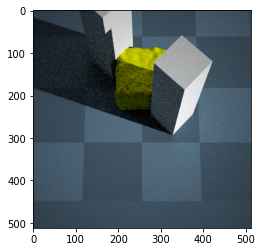

In [99]:
# env.render(mode='plt')

In [12]:
images = []
states = []

for frame in range(40-1):
    print(f'{frame}', end="\r",)

    state = env.get_state()

    # env.step(calc_shape_states_dx(frame * dt, gripper_config))
    env.step(np.concatenate([d['shape_states'][0][frame+1][0, 0:3] - d['shape_states'][0][frame][0, 0:3], d['shape_states'][0][frame+1][1, 0:3] - d['shape_states'][0][frame][1, 0:3]]) * 100)

    images.append(env.render('rgb_array'))

    state = env.get_state()

    positions.append(np.concatenate((state['state'][0], np.ones([len(state['state'][0]), 1])), 1))

    sts = np.array(state['state'][4:6])
    shape_states.append(np.concatenate([sts[:, :3], sts[:, :3], sts[:, 3:], sts[:, 3:]], axis=1))

    states = {
            'positions': np.array([positions]),
            'shape_states': np.array([shape_states]),
            'E': params[param_i][0], 
            'YS': params[param_i][1], 
            'nu': params[param_i][2]
            }

    with open('{:0>4}.npy'.format(str(param_i)), 'wb') as f:
            np.save(f, states)


    animate(images, '{:0>4}.webm'.format(str(param_i)))

[W 03/02/22 23:34:39.484 286446] [type_check.cpp:visit@100] [$8379] Local store may lose precision (target = f32, value = f64) at
[W 03/02/22 23:34:39.484 286446] [type_check.cpp:visit@101] 

[W 03/02/22 23:34:39.484 286446] [type_check.cpp:visit@100] [$8381] Local store may lose precision (target = f32, value = f64) at
[W 03/02/22 23:34:39.484 286446] [type_check.cpp:visit@101] 

[W 03/02/22 23:34:39.484 286446] [type_check.cpp:visit@100] [$8383] Local store may lose precision (target = f32, value = f64) at
[W 03/02/22 23:34:39.484 286446] [type_check.cpp:visit@101] 

[W 03/02/22 23:34:39.484 286446] [type_check.cpp:visit@100] [$8385] Local store may lose precision (target = f32, value = f64) at
[W 03/02/22 23:34:39.484 286446] [type_check.cpp:visit@101] 

[W 03/02/22 23:34:39.484 286446] [type_check.cpp:visit@100] [$8387] Local store may lose precision (target = f32, value = f64) at
[W 03/02/22 23:34:39.484 286446] [type_check.cpp:visit@101] 

[W 03/02/22 23:34:39.484 286446] [type_c

[W 03/02/22 23:34:51.755 286446] [type_check.cpp:visit@100] [$67740] Local store may lose precision (target = f32, value = f64) at
[W 03/02/22 23:34:51.755 286446] [type_check.cpp:visit@101] 
  File "/home/issei/Documents/UCSD/SuLab/PlasticineLab/plb/engine/renderer/renderer.py", line 450, in render
    contrib = self.trace(pos, d)
  File "/home/issei/anaconda3/envs/py37/lib/python3.7/site-packages/taichi/lang/kernel_impl.py", line 50, in decorated
    return fun.__call__(*args)
  File "/home/issei/anaconda3/envs/py37/lib/python3.7/site-packages/taichi/lang/kernel_impl.py", line 122, in __call__
    ret = self.compiled(*args)
  File "/home/issei/Documents/UCSD/SuLab/PlasticineLab/plb/engine/renderer/renderer.py", line 356, in trace
    closest, normal, c, roughness, material = self.next_hit(pos, d)
  File "/home/issei/anaconda3/envs/py37/lib/python3.7/site-packages/taichi/lang/kernel_impl.py", line 50, in decorated
    return fun.__call__(*args)
  File "/home/issei/anaconda3/envs/py37/

NameError: name 'positions' is not defined

In [50]:
# test out parameters
params = [
    [40, 1000, 0.2],
    [5, 1000, 0.2],
    [200, 1000, 0.2],
    [40, 100, 0.2],
    [40, 5000, 0.2],
    [40, 1000, 0.1],
    [40, 1000, 0.3],
]

params = [
    [5, 100, 0],
    [5, 100, 0.45],
    [5, 3000, 0],
    [5, 3000, 0.45],
    [200, 100, 0],
    [200, 100, 0.45],
    [200, 3000, 0],
    [200, 3000, 0.45],
]

for param_i in range(len(params)):
    
    env.initialize()

    set_parameters(env, params[param_i][0], params[param_i][1], params[param_i][2])

    state = env.get_state()


    gripper_config = sample_gripper_config()
    x, v, F, C, p1, p2 = state['state']

    d = np.load("../RiceGrip/0002.npy", allow_pickle=True).item()

    # d['shape_states'][:, :, :, :3] -= d['shape_states'][0][0].mean(axis=0)[0:3]
    d['shape_states'][:, :, :, 0] /= 5
    d['shape_states'][:, :, :, 2] /= 5
    d['shape_states'][:, :, :, 0] += 0.5
    d['shape_states'][:, :, :, 2] += 0.5
    d['shape_states'][:, :, :, 1] = 0.16

    shape_states_ = d['shape_states'][0][0]

    p1[:3] = shape_states_[0][0:3]
    p2[:3] = shape_states_[1][0:3]
    p1[3:] = shape_states_[0][6:10]
    p2[3:] = shape_states_[1][6:10]


    new_state = {
        'state': (x, v, F, C, p1, p2),
        'is_copy': state['is_copy'],
        'softness': state['softness'],
    }
    env.set_state(**new_state)


    positions = []
    shape_states = []


    images = []
    states = []

    for frame in range(40-1):
        print(f'{frame}', end="\r",)

        state = env.get_state()
        
        positions.append(np.concatenate((state['state'][0], np.ones([len(state['state'][0]), 1])), 1))
        sts = np.array(state['state'][4:6])
        shape_states.append(np.concatenate([sts[:, :3], sts[:, :3], sts[:, 3:], sts[:, 3:]], axis=1))
        

        # env.step(calc_shape_states_dx(frame * dt, gripper_config))
        env.step(np.concatenate([d['shape_states'][0][frame+1][0, 0:3] - d['shape_states'][0][frame][0, 0:3], d['shape_states'][0][frame+1][1, 0:3] - d['shape_states'][0][frame][1, 0:3]]) * 100)

        images.append(env.render('rgb_array'))

    state = env.get_state()

    positions.append(np.concatenate((state['state'][0], np.ones([len(state['state'][0]), 1])), 1))

    sts = np.array(state['state'][4:6])
    shape_states.append(np.concatenate([sts[:, :3], sts[:, :3], sts[:, 3:], sts[:, 3:]], axis=1))

    states = {
            'positions': np.array([positions]),
            'shape_states': np.array([shape_states]),
            'E': params[param_i][0], 
            'YS': params[param_i][1], 
            'nu': params[param_i][2]
            }

    with open('params/{:0>4}.npy'.format(str(param_i)), 'wb') as f:
            np.save(f, states)


    animate(images, 'params/{:0>4}.webm'.format(str(param_i)))

animating params/0000.webm
Moviepy - Building video params/0000.webm.
Moviepy - Writing video params/0000.webm



Moviepy - Done !
Moviepy - video ready params/0000.webm
animating params/0001.webm
Moviepy - Building video params/0001.webm.
Moviepy - Writing video params/0001.webm



Moviepy - Done !
Moviepy - video ready params/0001.webm
animating params/0002.webm
Moviepy - Building video params/0002.webm.
Moviepy - Writing video params/0002.webm



Moviepy - Done !
Moviepy - video ready params/0002.webm
animating params/0003.webm
Moviepy - Building video params/0003.webm.
Moviepy - Writing video params/0003.webm



Moviepy - Done !
Moviepy - video ready params/0003.webm
animating params/0004.webm
Moviepy - Building video params/0004.webm.
Moviepy - Writing video params/0004.webm



Moviepy - Done !
Moviepy - video ready params/0004.webm
animating params/0005.webm
Moviepy - Building video params/0005.webm.
Moviepy - Writing video params/0005.webm



Moviepy - Done !
Moviepy - video ready params/0005.webm
animating params/0006.webm
Moviepy - Building video params/0006.webm.
Moviepy - Writing video params/0006.webm



Moviepy - Done !
Moviepy - video ready params/0006.webm
animating params/0007.webm
Moviepy - Building video params/0007.webm.
Moviepy - Writing video params/0007.webm



Moviepy - Done !
Moviepy - video ready params/0007.webm


In [10]:
# random parameter dataset
for param_i in range(1000):
    
    env.initialize()
    
    ys = 5 + np.random.random()*195
    E = 1000 + np.random.random()*4000
    nu = 0.1 + np.random.random()*0.2

    set_parameters(env, ys, E, nu)

    state = env.get_state()


    gripper_config = sample_gripper_config()
    x, v, F, C, p1, p2 = state['state']

    d = np.load("../RiceGrip/{:0>4}.npy".format(str(param_i)), allow_pickle=True).item()

    d['shape_states'][:, :, :, 0] /= 5
    d['shape_states'][:, :, :, 2] /= 5
    d['shape_states'][:, :, :, 0] += 0.5
    d['shape_states'][:, :, :, 2] += 0.5
    d['shape_states'][:, :, :, 1] = 0.16

    shape_states_ = d['shape_states'][0][0]

    p1[:3] = shape_states_[0][0:3]
    p2[:3] = shape_states_[1][0:3]
    p1[3:] = shape_states_[0][6:10]
    p2[3:] = shape_states_[1][6:10]


    new_state = {
        'state': (x, v, F, C, p1, p2),
        'is_copy': state['is_copy'],
        'softness': state['softness'],
    }
    env.set_state(**new_state)


    positions = []
    shape_states = []


    images = []
    states = []

    for frame in range(40-1):
        print(f'{frame}', end="\r",)

        state = env.get_state()
        
        positions.append(np.concatenate((state['state'][0], np.ones([len(state['state'][0]), 1])), 1))
        sts = np.array(state['state'][4:6])
        shape_states.append(np.concatenate([sts[:, :3], sts[:, :3], sts[:, 3:], sts[:, 3:]], axis=1))
        

        # env.step(calc_shape_states_dx(frame * dt, gripper_config))
        env.step(np.concatenate([d['shape_states'][0][frame+1][0, 0:3] - d['shape_states'][0][frame][0, 0:3], d['shape_states'][0][frame+1][1, 0:3] - d['shape_states'][0][frame][1, 0:3]]) * 100)

        images.append(env.render('rgb_array'))

    state = env.get_state()

    positions.append(np.concatenate((state['state'][0], np.ones([len(state['state'][0]), 1])), 1))

    sts = np.array(state['state'][4:6])
    shape_states.append(np.concatenate([sts[:, :3], sts[:, :3], sts[:, 3:], sts[:, 3:]], axis=1))

    states = {
            'positions': np.array([positions]),
            'shape_states': np.array([shape_states]),
            'YS': ys, 
            'E': E, 
            'nu': nu
            }

    with open('data/{:0>4}.npy'.format(str(param_i)), 'wb') as f:
            np.save(f, states)


    # animate(images, 'data/{:0>4}.webm'.format(str(param_i)))